In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from AutoValidator.model_tester import ModelTester
from utils.progress import ProgressBar
progress = ProgressBar()

In [4]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

In [5]:
class ExponentialMovingAvgEstimator():
    
    def __init__(self, horizon, back_horizon=None):
        self.horizon = horizon
        
        if back_horizon is None:
            back_horizon = horizon
        self.back_horizon = back_horizon
        
    def fit(self, train, labels):
        self.starting_horizon = labels[-(self.back_horizon):]
        
    def predict(self, data):
        comb_data = np.hstack([self.starting_horizon, data])
        
        return np.repeat(pd.Series(comb_data[::-1]).ewm(self.back_horizon, adjust=False).mean().dropna(axis=0).values[-len(data):][::-1], self.horizon).reshape(len(data), self.horizon)
    
    def __repr__(self):
        return 'Exp Moving Avg Estimator: (h={:d})'.format(self.horizon)

In [6]:
t = np.arange(0, 100)

In [7]:
ema = ExponentialMovingAvgEstimator(5, 10)

In [8]:
ema.fit(t[:80], t[:80])

In [9]:
t[80:]

array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
       97, 98, 99])

In [10]:
a = ema.predict(t[80:])

In [11]:
a

array([[79.36960591, 79.36960591, 79.36960591, 79.36960591, 79.36960591],
       [80.30656651, 80.30656651, 80.30656651, 80.30656651, 80.30656651],
       [81.23722316, 81.23722316, 81.23722316, 81.23722316, 81.23722316],
       [82.16094547, 82.16094547, 82.16094547, 82.16094547, 82.16094547],
       [83.07704002, 83.07704002, 83.07704002, 83.07704002, 83.07704002],
       [83.98474402, 83.98474402, 83.98474402, 83.98474402, 83.98474402],
       [84.88321842, 84.88321842, 84.88321842, 84.88321842, 84.88321842],
       [85.77154026, 85.77154026, 85.77154026, 85.77154026, 85.77154026],
       [86.64869429, 86.64869429, 86.64869429, 86.64869429, 86.64869429],
       [87.51356372, 87.51356372, 87.51356372, 87.51356372, 87.51356372],
       [88.36492009, 88.36492009, 88.36492009, 88.36492009, 88.36492009],
       [89.2014121 , 89.2014121 , 89.2014121 , 89.2014121 , 89.2014121 ],
       [90.02155331, 90.02155331, 90.02155331, 90.02155331, 90.02155331],
       [90.82370864, 90.82370864, 90.8

In [16]:
from AutoValidator.ErrorMetrics import calculate_all_errors

def speed_up_calc(tester, data, horizon):
    # Loading bar
    tester.progressBar.set_length(len(data.columns))

    # walk speed up
    for i, column in enumerate(data.columns):
        # Split into train and test data
        split = int(0.20 * len(data))
        train, test = data[column][:split].values, data[column][split:].values
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]

        tester.model.fit(train, train)
        pred = tester.model.predict(test)
        tester.predictions[column] = pred

        errors = {}
        for key, value in calculate_all_errors(train, test, pred, horizon).items():
            errors[key] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[column]], inplace=True)
        tester.errors = tester.errors.append(t)

        tester.progressBar.progress()

## 1 minute horizon

In [12]:
horizon = 1
ema = ExponentialMovingAvgEstimator(horizon, 10)

In [13]:
one_min_tester = ModelTester(data, ema, horizon, 0.20)

In [17]:
speed_up_calc(one_min_tester, data, horizon)

Progress: [####################] 100.0%


In [18]:
one_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,48.686330,143.332241,36.907777,17.243435,0.204714,152.77718,0.165226
window_1_1,56.984380,179.378999,41.464708,16.612374,0.282938,65.57303,0.190825
window_1_2,81.793375,206.838791,131.669398,25.048177,0.264181,-56.96869,0.251442
window_1_3,87.113376,216.935985,81.568212,24.608405,0.223029,39.88443,0.226303
window_1_4,98.537431,242.155538,97.888398,28.967307,0.329057,138.50936,0.341406


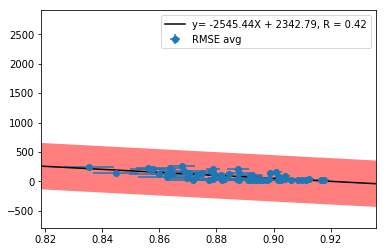

In [21]:
one_min_tester.compare_hurst(hurst_estimates)

In [19]:
one_min_tester.errors.to_csv('results/one_minute_exponential_moving_average_results.csv')

## 5 minute horizon

In [22]:
horizon = 5

ema = ExponentialMovingAvgEstimator(horizon, 10)

In [23]:
five_min_tester = ModelTester(data, ema, horizon, 0.20)

In [24]:
speed_up_calc(five_min_tester, data, horizon)

Progress: [####################] 100.0%


In [25]:
five_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,54.046242,154.211045,45.151779,19.641564,0.227252,169.59652,0.183407
window_1_1,62.789439,193.735450,45.725177,19.050381,0.311761,72.25302,0.210257
window_1_2,88.933785,221.182967,114.361144,27.794069,0.287243,-61.94195,0.273388
window_1_3,94.870279,232.580807,91.792351,27.080933,0.242888,43.43588,0.246467
window_1_4,106.737880,259.285216,114.410065,31.880199,0.356441,150.03634,0.369848


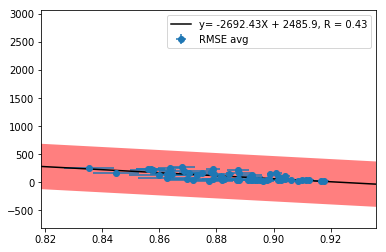

In [36]:
five_min_tester.compare_hurst(hurst_estimates)

In [37]:
five_min_tester.errors.to_csv('results/five_minute_exponential_moving_average_results.csv')

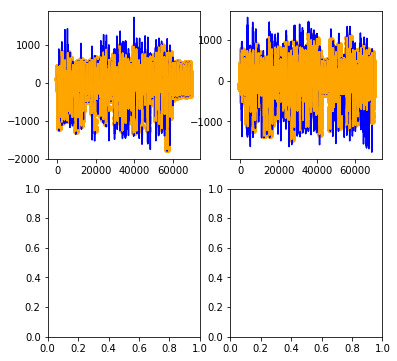

In [40]:
five_min_tester.visualise_result([1, 2])

## 60 minute horizon

In [28]:
horizon = 60
ema = ExponentialMovingAvgEstimator(horizon, 60)

In [29]:
sixty_min_tester = ModelTester(data, ema, horizon, 0.20)

In [30]:
speed_up_calc(sixty_min_tester, data, horizon)

Progress: [####################] 100.0%


In [33]:
sixty_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,132.300207,242.054558,172.311725,56.565738,0.556291,415.15662,0.448806
window_1_1,137.092096,282.108444,159.682285,51.192033,0.680688,157.75452,0.458915
window_1_2,171.125049,322.677861,167.697805,60.497722,0.552709,-119.18776,0.525917
window_1_3,188.449917,337.460672,133.545746,59.234444,0.482472,86.28086,0.489884
window_1_4,188.466289,352.928107,385.100991,69.440451,0.629366,264.91807,0.653216


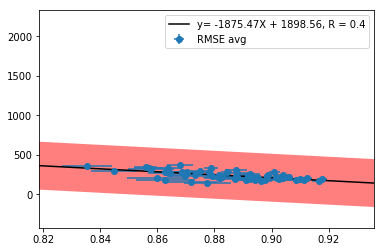

In [35]:
sixty_min_tester.compare_hurst(hurst_estimates)

In [34]:
sixty_min_tester.errors.to_csv('results/sixty_minute_exponential_moving_average_results.csv')